## Final Model -- Facial Keypoint Prediction

In this notebook, we walk through a model from the tutorial referenced by the official Kaggle competition website. It was constructed by Daniel Nouri. We will use this model as the baseline of our final project.

### 0. Fire up Neural Nets Libraries

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer
    
np.random.seed(42)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Path

We will further split the provided training data into our training set and development set in step 4.

In [21]:
FTRAIN = '~/data/training.csv'
FTEST = '~/data/test.csv'
FLOOKUP = '~/data/IdLookupTable.csv'

IDXTRAIN = 'train_indices.txt'
IDXDEV = 'dev_indices.txt'

### 2. View Raw Data

In [24]:
# Each row of our data refers to one face. 
# The first 30 columns refers to the labels of different facial keypoints. 
# A feature vector in the last column store pixel values of the facial image.

read_csv(FTRAIN).head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [25]:
# Testing data has no targets available
read_csv(FTEST).head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


### 3. Transforming Data

In [3]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load(test = False, dev = False,cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #Load pandas dataframe
    
    if (not test) and dev:
        load_idx = [int(line.rstrip('\n')) for line in open(IDXDEV)]
    elif (not test) and (not dev):    
        load_idx = [int(line.rstrip('\n')) for line in open(IDXTRAIN)]       
    
    if load_idx: df = df.loc[load_idx]
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna()

    # drop all rows that have missing values in them. 
    # if argument cols in not specified, this reduce from 7049 partial to 2140 full examples
    # potentially a problem training a neural net with fewer examples
    # should consider data augmentation in upcoming models
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid
    
    # Loading the 30 labels(targets)(keypoints) y for each face into an array
    if not test: # only training examples have target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle training data
        y = y.astype(np.float32)
        
    else:
        y = None # development data has no targets available
        
    return X,y,df.index

In [4]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(test=False, dev=False, cols=None):
    X, y, idx = load(test=test, dev=dev, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y, idx

### 4. Splitting into training and development set

In [5]:
from sklearn import model_selection
# help(model_selection.train_test_split)
# keep random state = 0 -- we need the same development set to compare our Baseline with other models
X_train, X_dev, y_train, y_dev, train_idx, test_idx = model_selection.train_test_split(X, y, range(len(X)), test_size=200, shuffle=True, random_state=0)
(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

# There are 1940 training examples and 200 development examples

((1940, 1, 96, 96), (200, 1, 96, 96), (1940, 30), (200, 30))

In [6]:
# double check if random state is producing the same split
train_idx[100] == 1410

True

### 5.0 Data Augmentation

### 5.1.1 General blurring, whole image

In [7]:
import copy
# generalized blurring function
# X is a single row of image data
# r is the radius of blurring (averages all pixels up-down-left-right of iteration of pixels)
# avoids borders for simplicity
# called in other blurring functions

def blur_range(X,r,i_range,j_range):
    if r>=0 and r<11:

        fig=copy.deepcopy(X)  # for protection

        horz_moves=range(-r,r+1) # all possible movements in i-direction (rows) from pixel
        vert_moves=range(-r,r+1) # same for j-direction (columns)
        
        horz_canvas=i_range
        vert_canvas=j_range

        Arr = np.reshape(fig,(96,96)) # creates np 96x96 array to work with

        for i in horz_canvas:  # scan X columns, stay in bounds, dont care about edges (sorry)
            for j in vert_canvas:  #scan Y rows, stay in bounds

                area=[]                        # blank list for area pixel vals
                for rows in horz_moves:        # row cycle 
                    for cols in vert_moves:      # col cycle
                        area.append(Arr[i+rows,j+cols])      #keep appending area list with vals
                Arr[i,j]=np.mean(area)   

        return np.ravel(Arr)

    else: 
        print('radius between 0 and 10')
        
# blur entire picture 
def blur_radius(X,r):
    
    i_range=range(r,96-r) # scan X columns, stay in bounds, dont care about edges (sorry)
    j_range=range(r,96-r)#scan Y rows, stay in bounds
    
    return blur_range(X,r,i_range,j_range)

In [ ]:
#blurring with radius 1 to maintain some image distinction
X_train_blur=np.apply_along_axis(blur_radius,1,X_train,1)

#X_train_blur=np.apply_along_axis(train_blur,1,X_dev,1)

### 5.2 Contrast (fingerprint motif)

In [6]:
# f is a contrast factor: 1/f addition or subtraction if higher or lower than area mean (1 pixel in all directions)
# resulting patter looks like fingerprint contours on image
def contrast_b(X,f):
    
    
    Arr=copy.deepcopy(X)  # for protection
    
    Arr = np.reshape(Arr,(96,96)) # creates np 96x96 array to work with 
    Arr_out=np.zeros((96,96))   # blank array to fill in values

    for i in range(1,95):  # scan X columns, stay in bounds, dont care about edges (sorry)
        for j in range(1,95):  #scan Y rows, stay in bounds

            area=[]                        # blank list for area pixel vals
            for rows in range(-1,2):        # row cycle 
                for cols in range(-1,2):      # col cycle
                    area.append(Arr[i+rows,j+cols])      #keep appending area list with vals
            
            
            if np.mean(area)< Arr[i,j]:
                Arr_out[i,j]= Arr[i,j] + (1-Arr[i,j])/f
            else:
                Arr_out[i,j]= Arr[i,j] - (1-Arr[i,j])/f

    return np.ravel(Arr_out)
    

In [ ]:
#apply contrast function along axis, using factor 1/4 addition/substraction for balanced contrast. 

X_train_contrast_b=np.apply_along_axis(contrast_b,1,X_train,4)

#X_dev_contrast_b=np.apply_along_axis(contrast_b,1,X_dev,4)

### 5.3 Flipping half of the image on the fly

In [2]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

NameError: name 'read_csv' is not defined

In [6]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

### 5.x stack transformed training sets into one training_x label_y

In [ ]:
# make sure each X_train_transform is accompanied by a y_train in the stack 

X_train_combo=np.vstack((X_train_blur,X_train_contrast_b))
y_train_combo=np.vstack((y_train,y_train))
    
# if total size not the same, del each combo array
# we could place checks on each vstack operation, but production sets would be controlled and predictable
if X_train_combo.shape[0]!=y_train_combo.shape[0]:
    del X_train_combo
    del Y_train_combo

### 6. Adjust Variable -- function to update parameters such as learning rate and moment with epochs 

In [7]:
def float32(k):
    return np.cast['float32'](k)

In [10]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

### 7. Early Stopping -- doesn't have to run max epochs once validation loss stablizes 

In [11]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

### 8. Convolutional Neural Net Specification

In [12]:
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10000,
    verbose=1,
    )

### 9. Train and store the model

In [13]:
time0 = time()
net12.fit(X_train, y_train)
print(time()-time0)


with open('net12.pickle', 'wb') as f:
    pickle.dump(net12, f, -1)

NameError: name 'X_train' is not defined

### 9.5 Load the Pickle 
(if net is train already)

In [12]:
fname_pretrain = 'net12.pickle'
with open(fname_pretrain, 'rb') as f:  # !
    net_pretrain = pickle.load(f)

In [16]:
net_pretrain.save_params_to('net_pretrain_saved_params.txt')

### 9.6 Create Specialists Dictionary

In [14]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

SPECIALIST_NAMES = ["eye_center", "nose_tip", "mouth_corner", "mouth_center", "eye_corner", "eyebrow"]
SPECIALIST_OUTPUTNODES = [4,2,6,2,8,8]

### 9.7 Train Specialists 

In [22]:
net_pretrain = None

# create dictionary to store specialists
specialists = OrderedDict()

i = 0
# loop through specialists one by one
for i in range(len(SPECIALIST_SETTINGS)):
    setting = SPECIALIST_SETTINGS[i]
    specialist_name = SPECIALIST_NAMES[i]
    cols = setting['columns']
    X_specialist, y_specialist, idx = load2d(cols=cols)
    print ("y output nodes:", y_specialist.shape[1])
    print ("-------------------------------------------------------")
    print ("Specialist:",i)
    print ("# examples used:", X_specialist.shape[0])
    # clone pretrained net
    model = clone(net12) 
    # adjust number of output nodes
    model.output_num_units = y_specialist.shape[1] 
    # adjust indices to flip
    model.batch_iterator_train.flip_indices = setting['flip_indices']
    # redefine max number to epochs to lower
    model.max_epochs = 3000   
    # model.max_epochs = int(4e6 / y_specialist.shape[0])
    
    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    if net_pretrain is not None:
        # if a pretrain model was given, use it to initialize the
        # weights of our new specialist model:
        model.load_params_from(net_pretrain)   

    print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
    model.fit(X_specialist, y_specialist)
    specialists[specialist_name] = model


left_eye_center_x     6839
left_eye_center_y     6839
right_eye_center_x    6836
right_eye_center_y    6836
Image                 6849
dtype: int64
y output nodes: 4
-------------------------------------------------------
Specialist: 0
# examples used: 6833
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01031   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01392   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04424   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02099   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02599   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04588   

In [23]:
# OPTION 1: as pickles
with open('net-specialists.pickle', 'wb') as f:
    # this time we're persisting a dictionary with all models:
    pickle.dump(specialists, f, -1)

# OPTION 2: as params
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i]
    specialist_model = specialists[specialist_name]
    file_name = "specialist_"+str(specialist_name)+"_saved_params.txt"
    specialist_model.save_params_to(file_name)

# 9.7.2 Load Specialists

In [27]:
# OPTION 1: as pickles
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    models = pickle.load(f)

In [ ]:
# OPTION 2: as params
FILE_NAMES = ['specialist_mouth_center_saved_params.txt',
             'specialist_nose_tip_saved_params.txt',
             'specialist_mouth_corner_saved_params.txt',
             'specialist_mouth_center_saved_params.txt',
             'specialist_eye_corner_saved_params.txt',
             'specialist_eyebrow_saved_params.txt']

models = OrderedDict()
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i] 
    file_name = FILE_NAMES[i]
    num_output_nodes = SPECIALIST_OUTPUTNODES[i]
    specialist_model = clone(net12)
    specialist_model.max_epochs = 3000
    specialist_model.output_num_units = num_output_nodes
    
    specialist_model.load_params_from(file_name)
    models[specialist_name] = specialist_model

### 9.8 Plot their error curves

In [28]:
def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


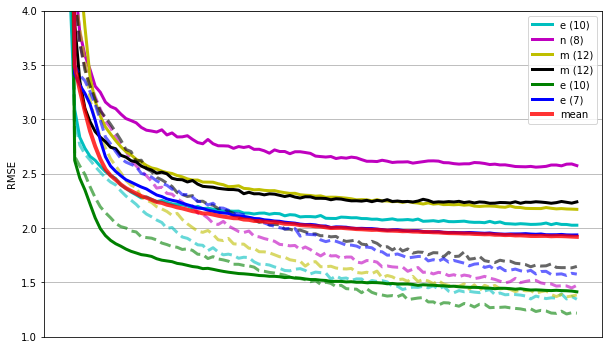

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

valid_losses = []
train_losses = []

for model_number, (cg, model) in enumerate(models.items(), 1):
    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) * 48
    train_loss = np.sqrt(train_loss) * 48
    valid_loss = rebin(valid_loss, (100,))
    train_loss = rebin(train_loss, (100,))
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss,label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6)
    ax.set_xticks([])

weights = np.array([m.output_num_units for m in models.values()],dtype=float)
weights /= weights.sum()
mean_valid_loss = (np.vstack(valid_losses) * weights.reshape(-1, 1)).sum(axis=0)
ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)
ax.legend()
ax.set_ylim((1.0, 4.0))
ax.grid()
plt.ylabel("RMSE")
plt.show()

In [40]:
mean_valid_loss[99]

1.9193458468468299

### 9.9 Make predictions to submit to Kaggle

In [15]:
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    specialists = pickle.load(f)

In [36]:
X = load2d(test=True)[0]
y_pred = np.empty((X.shape[0], 30))

for model in specialists.values():
    y_pred1 = model.predict(X)
    y_pred = np.vstack([y_pred, y_pred1]) # changed from hstack to vstack to force it to run but don't think this is really working
    
columns = ()
for cols in specialists.keys():
    columns += cols
    
y_pred2 = y_pred * 48 + 48
y_pred2 = y_pred2.clip(0, 96)

df = DataFrame(y_pred2, columns=columns)

lookup_table = read_csv(os.path.expanduser(FLOOKUP))
values = []

for index, row in lookup_table.iterrows():
    values.append((row['RowId'],df.ix[row.ImageId - 1][row.FeatureName],))

now_str = datetime.now().isoformat().replace(':', '-')
submission = DataFrame(values, columns=('RowId', 'Location'))
filename = 'submission-{}.csv'.format(now_str)
submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

UnboundLocalError: local variable 'load_idx' referenced before assignment

# END OF TUTORIAL CODE


### 10. Study In-sample Training and Validation Loss

Note that this "Training" and "Validation" data came from our 1940 training examples only. The Neural Net call automatically split 0.1 of these 1940 examples internally for its validation set. This has nothing to do with our development set, which is necessary for us to later compare with other models such as SVM or Logistic Regression.

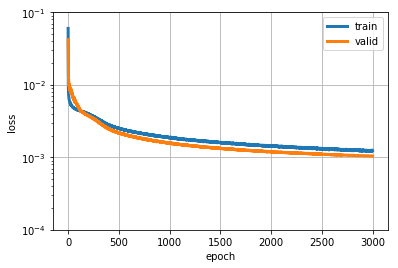

In [96]:
# object net12 keeps training history for each epoch
# we can access this record
train_loss = np.array([i["train_loss"] for i in net_pretrain.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net_pretrain.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-4,1e-1)
plt.yscale("log")
plt.show()

In [19]:
# Our validation error is 0.003255 here
# we need to convert this back 
np.sqrt(0.00079)*48
# now it returns a proxy value for the Kaggle board score

1.3491330549652989

### 11. Plot in-sample predictions : training set
how well does the model fit to training examples fed into it?

In [16]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap = 'gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


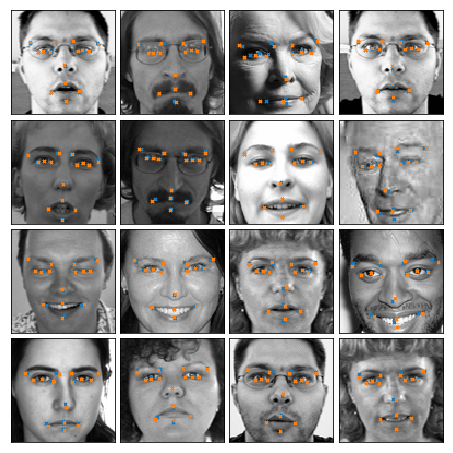

In [17]:
# load test set and predict
y_train_pred = net12.predict(X_train)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# predicted by model
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train_pred[i], ax)

# training labels
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train[i], ax)    

plt.show()

# cyan--our model prediction on training examples
# orange--real keypoints on training examples

### 12. Plot out-of-sample predictions : development set
how well does the model perform on the development set?

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


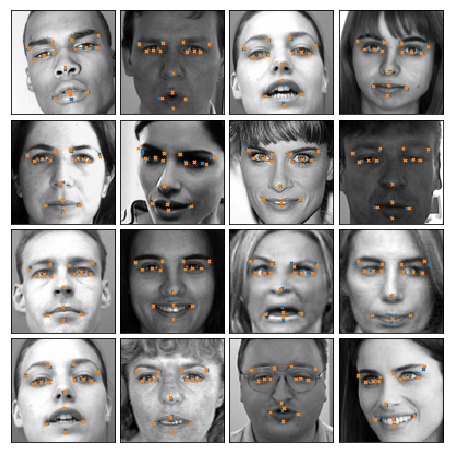

In [18]:
# load test set and predict
#X, _ = load(test=True)
y_dev_pred = net12.predict(X_dev)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev_pred[i], ax)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev[i], ax)
    
plt.show()

# cyan--our model prediction on development examples
# orange--real keypoints on development examples

### 12.5 Out-of-sample MSE: Development Set

In [19]:
mean_squared_error(y_dev, y_dev_pred)

0.00086455792

In [20]:
np.sqrt(mean_squared_error(y_dev, y_dev_pred))*48

1.4113615751266479

### 13. How will it look on the test set?
Note that we have no labels available, this is just a preview of how the model will perform on test set

ImageId    1783
Image      1783
dtype: int64


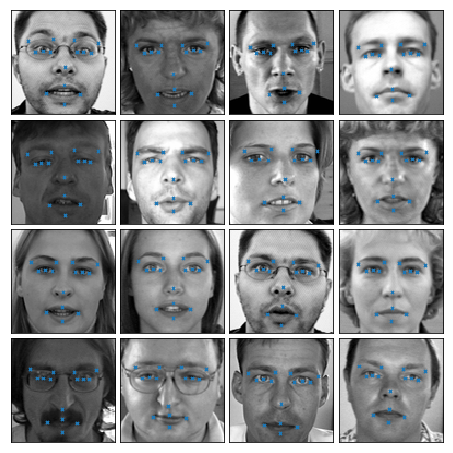

In [21]:
# load test set and predict
X_test, _ = load2d(test=True)
y_test_pred = net12.predict(X_test)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test_pred[i], ax)
    
plt.show()